In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import shutil
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Split train,valid,test(執行該部分可將原資料集依照指定比例切分訓練、驗證、測試集)

In [ ]:
#找出要準備切分訓練、測試、驗證資料集的總資料集
data_path = "H:\\AICUP\\dataset_org_crop\\"
os.path.exists(data_path)

In [ ]:
os.listdir(data_path)

In [ ]:
def image_preprocessing(img_path, img_size):
    img = cv2.imread(img_path)
#     h, w, _ = img.shape
#     lmax = max(h, w)
    
#     if h!=w and lmax==h:
#         err = h-w
#         img = np.concatenate([np.zeros((h, err//2, 3), dtype="uint8"), img, np.zeros((h, err-err//2, 3))], 1)
#     elif h!=w and lmax==w:
#         err = w-h
#         img = np.concatenate([np.zeros((err//2, w, 3), dtype="uint8"), img, np.zeros((err-err//2, w, 3))], 0)
    return img

In [ ]:
def data_open_save(data_path, new_path, img_size, data_split=True, data_split_rate=[0.995, 0.0025, 0.0025]):
    #先建立兩個list儲存資料路徑跟對應的label
    data_path_list, data_label_list = [], []
    
    for root, dirs, files in os.walk(data_path):
        if len(files)!=0:
            label = root.split("\\")[-1] # D:\yzheng\dataset_400\asparagus
            if data_split:
                split_names = ["train", "valid", "test"]            
                for each_name in split_names:
                    #new_root = os.path.join(new_path, each_name, label)
                    new_root=new_path+"\\"+each_name+"\\"+label
                    if not os.path.exists(new_root):
                        os.makedirs(new_root)
            else:
                #new_root = os.path.join(new_path, label)
                new_root=new_path+"\\"+label
                if not os.path.exists(new_root):
                    os.makedirs(new_root)
        
        for file in files:
            #img_path = os.path.join(root, file)
            img_path=root+"\\"+file
            label = root.split("\\")[-1]
            data_path_list.append(img_path)
            data_label_list.append(label)
            print(img_path)

    data_list = pd.DataFrame({"img_path":data_path_list, "label":data_label_list})
    class_map = { label: i for i, label in enumerate(data_list["label"].unique().copy())}
    data_list["label_class"] = data_list["label"].map(class_map)

    if data_split:
        train_list, test_list = train_test_split(data_list,
                            test_size=sum(data_split_rate[-2:]),
                            random_state=2,
                            stratify=data_list["label_class"])
        valid_list, test_list = train_test_split(test_list,
                            test_size=data_split_rate[-1]/sum(data_split_rate[-2:]),
                            random_state=2,
                            stratify=test_list["label_class"])
  
        data_types = [train_list["img_path"].values, valid_list["img_path"].values, test_list["img_path"].values]
        split_names = ["train", "valid", "test"]
    else:
        data_types = [data_path_list]
        split_names = [""]

    for each_list, each_name in zip(data_types, split_names):
        for img_path in each_list:
            label, file = img_path.split("\\")[-2:]
            #new_root = os.path.join(new_path, each_name, label)
            new_root=new_path+"\\"+each_name+"\\"+label
            #img_newpath = os.path.join(new_root, file)
            img_newpath=new_root+"\\"+file
            img = image_preprocessing(img_path, img_size)
            if not cv2.imwrite(img_newpath, img):
                raise Exception('Wrong')
            

In [ ]:
new_path = "H:\\AICUP\\trainset_org_400"#切分資料集後的目標路徑
img_size = (800,800)
data_open_save(data_path, new_path, img_size=img_size, data_split=True, data_split_rate=[0.995, 0.0025, 0.0025])

# Train model(利用前一部分所得出的訓練集來進行訓練模型)

In [ ]:
data_path = "H:\\AICUP\\trainset"
os.path.exists(data_path)

True

In [ ]:
def DataList(data_path):
  img_list, data_label, data_types = [], [], []
  class_path = ""
  for root, dirs, files in os.walk(data_path):
    if root.split("\\")[-1]!="model-logs":
      for file in files:
        if file.find("checkpoint")==-1:
          if file[-3:]=="csv":
            #class_path = os.path.join(root, file)
            class_path=root+"\\"+file
          else:
            #img_list.append(os.path.join(root, file))
            img_list.append(root+"\\"+file)
            label = root.split("\\")[-1]
            types = root.split("\\")[-2]
            data_label.append(label)
            data_types.append(types)
  data_list = pd.DataFrame({"img_path":img_list, "label_name":data_label, "types":data_types})
  
  if class_path != "":
    class_map = pd.read_csv(class_path, header=None)
    class_map = dict(class_map.values)
  else:
    class_map = data_list[data_list["types"]=="train"]["label_name"].unique()
    class_map = {label: str(i) for i, label in enumerate(class_map)}
    print(class_map)

  data_list["label"] = data_list["label_name"].map(class_map)
  
  train_list = data_list[data_list["types"]=="train"][["img_path", "label_name", "label"]].copy()
  valid_list = data_list[data_list["types"]=="valid"][["img_path", "label_name", "label"]].copy()
  test_list = data_list[data_list["types"]=="test"][["img_path", "label_name", "label"]].copy()

  return train_list, valid_list, test_list, class_map

In [ ]:
train_list, valid_list, test_list, class_map = DataList(data_path)

{'asparagus': '0', 'bambooshoots': '1', 'betel': '2', 'broccoli': '3', 'cauliflower': '4', 'chinesecabbage': '5', 'chinesechives': '6', 'custardapple': '7', 'grape': '8', 'greenhouse': '9', 'greenonion': '10', 'kale': '11', 'lemon': '12', 'lettuce': '13', 'litchi': '14', 'longan': '15', 'loofah': '16', 'mango': '17', 'onion': '18', 'others': '19', 'papaya': '20', 'passionfruit': '21', 'pear': '22', 'pennisetum': '23', 'redbeans': '24', 'roseapple': '25', 'sesbania': '26', 'soybeans': '27', 'sunhemp': '28', 'sweetpotato': '29', 'taro': '30', 'tea': '31', 'waterbamboo': '32'}


In [ ]:
train_list

,img_path,label_name,label
224,H:\AICUP\trainset\train\asparagus\000b43a3-d33...,asparagus,0
225,H:\AICUP\trainset\train\asparagus\00172189-315...,asparagus,0
226,H:\AICUP\trainset\train\asparagus\002aec7b-648...,asparagus,0
227,H:\AICUP\trainset\train\asparagus\007cd63a-333...,asparagus,0
228,H:\AICUP\trainset\train\asparagus\00a326ba-7e9...,asparagus,0
...,...,...,...
89285,H:\AICUP\trainset\train\waterbamboo\ffb5fc02-3...,waterbamboo,32
89286,H:\AICUP\trainset\train\waterbamboo\ffd7568f-f...,waterbamboo,32
89287,H:\AICUP\trainset\train\waterbamboo\ffd9c5f8-e...,waterbamboo,32
89288,H:\AICUP\trainset\train\waterbamboo\fff0cfff-8...,waterbamboo,32


In [ ]:
class_map={'asparagus':0,'bambooshoots':1,'betel':2,'broccoli':3,'cauliflower':4,'chinesecabbage':5,'chinesechives':6,
               'custardapple':7,'grape':8,'greenhouse':9,'greenonion':10,'kale':11,'lemon':12,'lettuce':13,'litchi':14,
               'longan':15,'loofah':16,'mango':17,'onion':18,'others':19,'papaya':20,'passionfruit':21,'pear':22,
               'pennisetum':23,'redbeans':24,'roseapple':25,'sesbania':26,'soybeans':27,'sunhemp':28,'sweetpotato':29,
               'taro':30,'tea':31,'waterbamboo':32}

In [ ]:
class_map.keys()

dict_keys(['asparagus', 'bambooshoots', 'betel', 'broccoli', 'cauliflower', 'chinesecabbage', 'chinesechives', 'custardapple', 'grape', 'greenhouse', 'greenonion', 'kale', 'lemon', 'lettuce', 'litchi', 'longan', 'loofah', 'mango', 'onion', 'others', 'papaya', 'passionfruit', 'pear', 'pennisetum', 'redbeans', 'roseapple', 'sesbania', 'soybeans', 'sunhemp', 'sweetpotato', 'taro', 'tea', 'waterbamboo'])

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [ ]:
num_classes = train_list["label"].unique().shape[0]
num_classes

33

In [ ]:
img_shape = (800,800)
batch_size = 8

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.applications.xception import Xception,preprocess_input

In [ ]:
train_datagen = ImageDataGenerator(
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range=0.2,
                    preprocessing_function=preprocess_input
                    )
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
                              dataframe=train_list,
                              directory="",
                              x_col="img_path",
                              y_col="label_name",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical')
valid_generator = valid_datagen.flow_from_dataframe(
                              dataframe=valid_list,
                              directory="",
                              x_col="img_path",
                              y_col="label_name",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical',
                              shuffle=False)
test_generator = test_datagen.flow_from_dataframe(
                              dataframe=test_list,
                              directory="",
                              x_col="img_path",
                              y_col="label_name",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode=None,
                              shuffle=False)

Found 71611 validated image filenames belonging to 33 classes.
Found 8951 validated image filenames belonging to 33 classes.
Found 8952 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 800, 800, 3)
(800, 800, 3) 1.0 -1.0


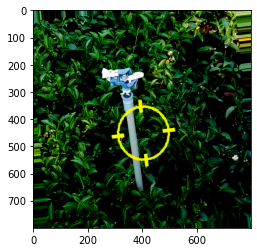

In [ ]:
(data_train,label_train)= train_generator.next()
print(data_train.shape)
img=data_train[-1,:,:,:]
img=img
print(img.shape,img.max(),img.min())
plt.imshow(img)

In [ ]:
pre_model = DenseNet121(weights='imagenet', input_shape=(img_shape[0], img_shape[1], 3), include_top=False)

x = layers.GlobalAveragePooling2D()(pre_model.output)
# x = layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

In [ ]:
model = keras.models.Model(inputs=pre_model.inputs, outputs=outputs)

In [ ]:
def lr_schedule(epoch):
    lrate=0.001
    if epoch>13:
        lrate=0.0005
    if epoch>17:
        lrate=0.0001
    if epoch>25:
        lrate=0.00001
    return lrate

In [ ]:
import tensorflow as tf

model_dir = os.path.join(data_path, 'model-logs')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


modelfiles = model_dir + '/{}-best-model-test000.h5'.format('basic_model')
model_mckp = callbacks.ModelCheckpoint(modelfiles,
                      monitor='val_accuracy',
                      save_best_only=True)

lrschedule=tf.keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks_list = [model_mckp,lrschedule]

In [ ]:
def num_steps_per_epoch(data_generator, batch_size):
  if data_generator.n % batch_size==0:
    return data_generator.n//batch_size
  else:
    return data_generator.n//batch_size + 1

In [ ]:
lr = 1e-3
batch_size = 8
num_epochs = 20

train_steps = num_steps_per_epoch(train_generator, batch_size)
valid_steps = num_steps_per_epoch(valid_generator, batch_size)

In [ ]:
optimizer = keras.optimizers.Adam(lr)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 406, 406, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 200, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

 conv2_block2_add (Add)         (None, 100, 100, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 100, 100, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 100, 100, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 100, 100, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 50, 50, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 50, 50, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 50, 50, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 50, 50, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 25, 25, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 25, 25, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 25, 25, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 25, 25, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 25, 25, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 25, 25, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
          

 conv5_block1_2_relu (Activatio  (None, 13, 13, 512)  0          ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 13, 13, 2048  2099200     ['conv4_block6_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 13, 13, 2048  1050624     ['conv5_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 13, 13, 2048  8192       ['conv5_block1_0_conv[0][0]']    
 ization) 

Total params: 23,655,329
Trainable params: 23,602,209
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [ ]:
pre_model.trainable = False

In [ ]:
history = model.fit(train_generator,
                  steps_per_epoch=train_steps,
                  epochs=num_epochs,
                  validation_data=valid_generator,
                  validation_steps=valid_steps,
                  callbacks=callbacks_list)

In [ ]:
pre_model.trainable = True
for each_layer in pre_model.layers[:-5]: #倒數五層
    each_layer.trainable = False

batch_size = 8
num_epochs = 30

train_steps = num_steps_per_epoch(train_generator, batch_size)
valid_steps = num_steps_per_epoch(valid_generator, batch_size)

In [ ]:
history = model.fit(train_generator,
                  steps_per_epoch=train_steps,
                  epochs=num_epochs,
                  validation_data=valid_generator,
                  validation_steps=valid_steps,
                  callbacks=callbacks_list,
                  initial_epoch=20)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from keras.models import model_from_json

In [ ]:
# model=keras.models.load_model('F:\\AICUP\\trainset_400\\model-logs\\Xception_800(0.756).h5')
# model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 199, 199, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 199, 199, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

                                                                                                  
 block4_sepconv1_bn (BatchNorma  (None, 50, 50, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 50, 50, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 50, 50, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_se

 block7_sepconv1_act (Activatio  (None, 25, 25, 728)  0          ['add_16[0][0]']                 
 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 25, 25, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 25, 25, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 25, 25, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)       

                                                                                                  
 block9_sepconv3_bn (BatchNorma  (None, 25, 25, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 25, 25, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 25, 25, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_s

 alization)                                                                                       
                                                                                                  
 block12_sepconv3_act (Activati  (None, 25, 25, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 25, 25, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 25, 25, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
          

In [ ]:
batch_size = 8
test_steps = num_steps_per_epoch(test_generator, batch_size)

In [ ]:
y_test = test_list["label"].values.astype(np.int_)

In [ ]:
y_test

array([ 0,  0,  0, ..., 32, 32, 32])

In [ ]:
y_test_predprob = model.predict(test_generator,verbose=1)
y_test_pred = y_test_predprob.argmax(-1)

1119/1119 [==============================] - 364s 324ms/step


In [ ]:
y_test_pred

array([ 0,  0,  0, ..., 23, 32,  8], dtype=int64)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

accuracy_score: 0.654


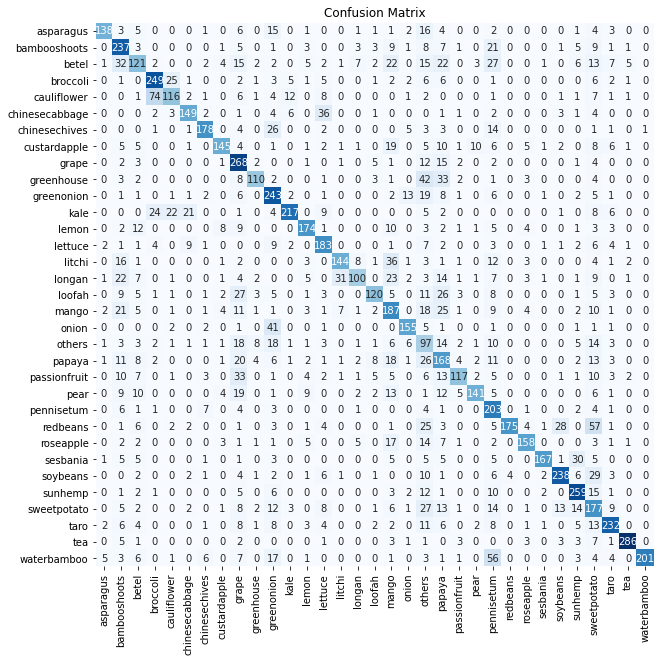

In [ ]:
print(f"accuracy_score: {accuracy_score(y_test, y_test_pred):.3f}")

plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
      cmap="Blues", annot=True, fmt="d", cbar=False,
      xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from  sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.68      0.77       204
           1       0.56      0.74      0.64       320
           2       0.52      0.38      0.44       319
           3       0.69      0.78      0.73       320
           4       0.66      0.48      0.56       240
           5       0.78      0.69      0.73       216
           6       0.84      0.74      0.79       240
           7       0.82      0.60      0.70       240
           8       0.52      0.84      0.65       320
           9       0.79      0.51      0.62       215
          10       0.55      0.77      0.64       316
          11       0.87      0.68      0.76       320
          12       0.77      0.73      0.75       239
          13       0.64      0.76      0.70       240
          14       0.77      0.60      0.67       240
          15       0.75      0.42      0.54       240
          16       0.75      0.50      0.60       240
          17       0.47    

In [ ]:
model.save('F:\\AICUP\\trainset_org_400\\model-logs\\Xception_org_org(0.774).h5')#儲存模型

In [ ]:
# 畫圖 train/test Accuracy plot
history.history.keys()
# # train/valid Plot
import matplotlib.pyplot as plt
plt.title('Accuracy of train and test')
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [ ]:
# 畫圖 train/test Loss/cost plot
plt.title('Loss of train and test')
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [ ]:
#F1-score
from  sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

# Grad Cam(執行該部分可將前面預測錯誤的圖片進行Grad Cam分析)(可忽略此部分)

In [ ]:
#model.save('D:\\AICUP\\trainset_400\\model-logs\\xception(0.607).h5')
#model=keras.models.load_model('D:\\AICUP\\trainset_400\\model-logs\\basic_model-best-model-test000.h5')

In [ ]:
#compare the differences between y_test_pred and y_test
index=0
wrong_index=list()
for i in range(len(y_test)):
    if y_test[i]!=y_test_pred[i]:
        wrong_index.append(index)
    index+=1
print(wrong_index)
print(len(wrong_index))

In [ ]:
wrong_img=list()
for i in wrong_index:
    wrong_img.append(test_list_new.iloc[i].img_path)
len(wrong_img)

In [ ]:
wrong_img_label=list()
for i in wrong_index:
    wrong_img_label.append(test_list_new.iloc[i].label)
len(wrong_img_label)

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
def show_gradcam(IMG_PATH,LAYER_NAME,CLASS_INDEX):

    img = tf.keras.preprocessing.image.load_img( IMG_PATH, target_size=(400,400) )
    img = tf.keras.preprocessing.image.img_to_array(img)

    img = np.array([img])  # Convert single image to a batch.

    #把影像進行對應的前處理
    img = preprocess_input(img)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, CLASS_INDEX]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (256, 256))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    output_image = cv2.addWeighted(cv2.cvtColor(img[0].astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

    #cv2.imwrite('cam.png', output_image)

    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    return plt.imshow(output_image)

In [ ]:
def predict_one(img_size,img_path,model_path):
    # load model
    model = keras.models.load_model(model_path)

    # preprocess image
    image = tf.keras.preprocessing.image.load_img( img_path, target_size=(img_size, img_size))
    input_arr = keras.preprocessing.image.img_to_array(image)
    input_arr = preprocess_input( np.array([input_arr]) ) # Convert single image to a batch.

    # predict on image
    predictions = model.predict(input_arr)
    return predictions.argmax()

In [ ]:
def show_result(img_size,img_path,model_path,LAYER_NAME,CLASS_INDEX):
    result=predict_one(img_size,img_path,model_path)
    print(CLASS_INDEX,'--->',result)
    show_gradcam(img_path,LAYER_NAME,CLASS_INDEX)

In [ ]:
img_size=256
model_path = 'D:\\AICUP\\trainset_400\\model-logs\\basic_model-best-model-test000.h5'
LAYER_NAME = 'block14_sepconv2_act' 

index=30 #change index to show different image
img_path=wrong_img[index]
plt.subplot(1,2,1)
img=Image.open(img_path)
plt.title(img_path)
plt.imshow(img)
plt.subplot(1,2,2)
CLASS_INDEX =int(wrong_img_label[index])
show_result(img_size,img_path,model_path,LAYER_NAME,CLASS_INDEX)